# ELC-144x142x79
---

**Version du modèle : ./model LMDZOR_v6.1.11**

Test with initial condition (on Jean-Zay):
> /gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZ/ELC-144x142x79/ATM/Output

that I created with 

> EXPERIMENTS/LMDZ/CREATE_clim_360d/config.card

Ce fichier va chercher le fichier Relief.nc suivant : `/gpfswork/rech/psl/commun/IGCM/ATM/Relief.nc`

that I copie on CICLAD: 

> /data/mlalande/ELC-144x142x79_clim


amip_CMIP6 -> /gpfswork/rech/psl/commun/IGCM/ATM/START/eORCA1.2xLMD144x142/startphy_eORCA1.2xLMD144x142x79_o2a_v3.nc

## Other comparisons:
- /data/mlalande/Relief/Relief_GMTED2010_15n030_0125deg.nc
- /data/mlalande/Relief/Relief_GMTED2010_15n015_00625deg.nc
- /bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc

that I will also compare with Laurent Fairhead ouputs when available

## Remarque:
- L'altitude se trouve dans le fichier /Grid/ELC-144x142x79_**grilles_gcm.nc** dans la variable **phis**
- Les variables ZMEA, ZSTD, etc. sont des variables moyennées sur 9 pixels (cf. grid_noro) et sont sur la grille physique dans startphy.nc donc à repasser en grille réelle (voir https://github.com/mickaellalande/PhD/blob/master/CICLAD/LMDZ_grid/LMDZ_grid_physics2dynamics.ipynb pour plus de détails)

PS : the reformatting of files was done in http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/Bias%20correlation%20with%20Relief.nc.ipynb

### Import modules

In [8]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 239 GB / percent used: 5.0 %


# Load CMIP6 orography

In [9]:
topo_CMIP6 = xr.open_dataarray(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc'
).load()
topo_CMIP6

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2841.648 , 2841.648 , 2841.648 , ..., 2841.648 , 2841.648 ,
        2841.648 ],
       [2688.9688, 2697.9724, 2708.5688, ..., 2658.9578, 2668.209 ,
        2677.9058],
       [2618.7102, 2638.589 , 2658.8015, ..., 2562.443 , 2580.6404,
        2599.4429],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

# Load default Relief.nc orography
(from CREATE_clim_360d)

In [4]:
xr.open_dataset('/data/mlalande/ELC-144x142x79_clim/Output/Boundary/ELC-144x142x79_clim_limit.nc')

<xarray.Dataset>
Dimensions:    (points_physiques: 20306, time: 360)
Dimensions without coordinates: points_physiques, time
Data variables:
    TEMPS      (time) float64 ...
    FOCE       (time, points_physiques) float64 ...
    FSIC       (time, points_physiques) float64 ...
    FTER       (time, points_physiques) float64 ...
    FLIC       (time, points_physiques) float64 ...
    SST        (time, points_physiques) float64 ...
    BILS       (time, points_physiques) float64 ...
    ALB        (time, points_physiques) float64 ...
    RUG        (time, points_physiques) float64 ...
    longitude  (points_physiques) float32 ...
    latitude   (points_physiques) float32 ...
Attributes:
    title:    Fichier conditions aux limites
    history:  File produced using ce0l executable.\nSea Ice Concentration bui...

In [26]:
xr.open_dataset('/data/mlalande/ELC-144x142x79_clim/Output/Restart/ELC-144x142x79_clim_startphy.nc')

<xarray.Dataset>
Dimensions:          (horizon_klevp1: 1624480, horizon_vertical: 1604174, index: 100, points_physiques: 20306)
Dimensions without coordinates: horizon_klevp1, horizon_vertical, index, points_physiques
Data variables:
    controle         (index) float64 ...
    longitude        (points_physiques) float64 ...
    latitude         (points_physiques) float64 ...
    masque           (points_physiques) float64 ...
    FTER             (points_physiques) float64 ...
    FLIC             (points_physiques) float64 ...
    FOCE             (points_physiques) float64 ...
    FSIC             (points_physiques) float64 ...
    TS01             (points_physiques) float64 ...
    TS02             (points_physiques) float64 ...
    TS03             (points_physiques) float64 ...
    TS04             (points_physiques) float64 ...
    A_dir_SW01srf01  (points_physiques) float64 ...
    A_dir_SW02srf01  (points_physiques) float64 ...
    A_dir_SW03srf01  (points_physiques) float64 ...
    A_dir_SW04srf01  (points_physiques) float64 ...
    A_dir_SW05srf01  (points_physiques) float64 ...
    A_dir_SW06srf01  (points_physiques) float64 ...
    A_dir_SW01srf02  (points_physiques) float64 ...
    A_dir_SW02srf02  (points_physiques) float64 ...
    A_dir_SW03srf02  (points_physiques) float64 ...
    A_dir_SW04srf02  (points_physiques) float64 ...
    A_dir_SW05srf02  (points_physiques) float64 ...
    A_dir_SW06srf02  (points_physiques) float64 ...
    A_dir_SW01srf03  (points_physiques) float64 ...
    A_dir_SW02srf03  (points_physiques) float64 ...
    A_dir_SW03srf03  (points_physiques) float64 ...
    A_dir_SW04srf03  (points_physiques) float64 ...
    A_dir_SW05srf03  (points_physiques) float64 ...
    A_dir_SW06srf03  (points_physiques) float64 ...
    A_dir_SW01srf04  (points_physiques) float64 ...
    A_dir_SW02srf04  (points_physiques) float64 ...
    A_dir_SW03srf04  (points_physiques) float64 ...
    A_dir_SW04srf04  (points_physiques) float64 ...
    A_dir_SW05srf04  (points_physiques) float64 ...
    A_dir_SW06srf04  (points_physiques) float64 ...
    A_dif_SW01srf01  (points_physiques) float64 ...
    A_dif_SW02srf01  (points_physiques) float64 ...
    A_dif_SW03srf01  (points_physiques) float64 ...
    A_dif_SW04srf01  (points_physiques) float64 ...
    A_dif_SW05srf01  (points_physiques) float64 ...
    A_dif_SW06srf01  (points_physiques) float64 ...
    A_dif_SW01srf02  (points_physiques) float64 ...
    A_dif_SW02srf02  (points_physiques) float64 ...
    A_dif_SW03srf02  (points_physiques) float64 ...
    A_dif_SW04srf02  (points_physiques) float64 ...
    A_dif_SW05srf02  (points_physiques) float64 ...
    A_dif_SW06srf02  (points_physiques) float64 ...
    A_dif_SW01srf03  (points_physiques) float64 ...
    A_dif_SW02srf03  (points_physiques) float64 ...
    A_dif_SW03srf03  (points_physiques) float64 ...
    A_dif_SW04srf03  (points_physiques) float64 ...
    A_dif_SW05srf03  (points_physiques) float64 ...
    A_dif_SW06srf03  (points_physiques) float64 ...
    A_dif_SW01srf04  (points_physiques) float64 ...
    A_dif_SW02srf04  (points_physiques) float64 ...
    A_dif_SW03srf04  (points_physiques) float64 ...
    A_dif_SW04srf04  (points_physiques) float64 ...
    A_dif_SW05srf04  (points_physiques) float64 ...
    A_dif_SW06srf04  (points_physiques) float64 ...
    U10M01           (points_physiques) float64 ...
    U10M02           (points_physiques) float64 ...
    U10M03           (points_physiques) float64 ...
    U10M04           (points_physiques) float64 ...
    V10M01           (points_physiques) float64 ...
    V10M02           (points_physiques) float64 ...
    V10M03           (points_physiques) float64 ...
    V10M04           (points_physiques) float64 ...
    Tsoil01srf01     (points_physiques) float64 ...
    Tsoil02srf01     (points_physiques) float64 ...
    Tsoil03srf01     (points_physiques) float64 ...
    Tsoil04srf01     (points_physiques) float64 ...
    Tsoil05srf01     (points_phys

In [28]:
xr.open_dataset('/data/mlalande/ELC-144x142x79_clim/Output/Restart/ELC-144x142x79_clim_start.nc')

<xarray.Dataset>
Dimensions:   (index: 100, rlatu: 143, rlatv: 142, rlonu: 145, rlonv: 145, sig: 80, sigs: 79, temps: 1)
Coordinates:
  * rlonu     (rlonu) float64 -3.12 -3.076 -3.033 -2.989 ... 3.076 3.12 3.163
  * rlatu     (rlatu) float64 1.571 1.549 1.527 1.504 ... -1.527 -1.549 -1.571
  * rlonv     (rlonv) float64 -3.142 -3.098 -3.054 -3.011 ... 3.054 3.098 3.142
  * rlatv     (rlatv) float64 1.56 1.538 1.515 1.493 ... -1.515 -1.538 -1.56
  * temps     (temps) datetime64[ns] 1979-01-01
Dimensions without coordinates: index, sig, sigs
Data variables:
    controle  (index) float64 ...
    nivsigs   (sigs) float64 ...
    nivsig    (sig) float64 ...
    ap        (sig) float64 ...
    bp        (sig) float64 ...
    presnivs  (sigs) float64 ...
    cu        (rlatu, rlonu) float64 ...
    cv        (rlatv, rlonv) float64 ...
    aire      (rlatu, rlonv) float64 ...
    phisinit  (rlatu, rlonv) float64 ...
    ucov      (temps, sigs, rlatu, rlonu) float64 ...
    vcov      (temps, sigs, rlatv, rlonv) float64 ...
    teta      (temps, sigs, rlatu, rlonv) float64 ...
    H2Ov      (temps, sigs, rlatu, rlonv) float64 ...
    H2Ol      (temps, sigs, rlatu, rlonv) float64 ...
    H2Oi      (temps, sigs, rlatu, rlonv) float64 ...
    Aga       (temps, sigs, rlatu, rlonv) float64 ...
    masse     (temps, sigs, rlatu, rlonv) float64 ...
    ps        (temps, rlatu, rlonv) float64 ...
Attributes:
    title:    Fichier demarrage dynamique

In [28]:
xr.open_dataset('/data/mlalande/ELC-144x142x79_clim/Output/Restart/ELC-144x142x79_clim_start.nc')

<xarray.Dataset>
Dimensions:   (index: 100, rlatu: 143, rlatv: 142, rlonu: 145, rlonv: 145, sig: 80, sigs: 79, temps: 1)
Coordinates:
  * rlonu     (rlonu) float64 -3.12 -3.076 -3.033 -2.989 ... 3.076 3.12 3.163
  * rlatu     (rlatu) float64 1.571 1.549 1.527 1.504 ... -1.527 -1.549 -1.571
  * rlonv     (rlonv) float64 -3.142 -3.098 -3.054 -3.011 ... 3.054 3.098 3.142
  * rlatv     (rlatv) float64 1.56 1.538 1.515 1.493 ... -1.515 -1.538 -1.56
  * temps     (temps) datetime64[ns] 1979-01-01
Dimensions without coordinates: index, sig, sigs
Data variables:
    controle  (index) float64 ...
    nivsigs   (sigs) float64 ...
    nivsig    (sig) float64 ...
    ap        (sig) float64 ...
    bp        (sig) float64 ...
    presnivs  (sigs) float64 ...
    cu        (rlatu, rlonu) float64 ...
    cv        (rlatv, rlonv) float64 ...
    aire      (rlatu, rlonv) float64 ...
    phisinit  (rlatu, rlonv) float64 ...
    ucov      (temps, sigs, rlatu, rlonu) float64 ...
    vcov      (temps, sigs, rlatv, rlonv) float64 ...
    teta      (temps, sigs, rlatu, rlonv) float64 ...
    H2Ov      (temps, sigs, rlatu, rlonv) float64 ...
    H2Ol      (temps, sigs, rlatu, rlonv) float64 ...
    H2Oi      (temps, sigs, rlatu, rlonv) float64 ...
    Aga       (temps, sigs, rlatu, rlonv) float64 ...
    masse     (temps, sigs, rlatu, rlonv) float64 ...
    ps        (temps, rlatu, rlonv) float64 ...
Attributes:
    title:    Fichier demarrage dynamique

In [11]:
phis_def = xr.open_dataset('/data/mlalande/ELC-144x142x79_clim/Output/Grid/ELC-144x142x79_grilles_gcm.nc').phis
phis_def

<xarray.DataArray 'phis' (latu: 143, lonv: 145)>
array([[   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       ...,
       [2925.417 , 2893.005 , 2857.261 , ..., 2975.1013, 2952.84  , 2925.417 ],
       [3013.4026, 3010.317 , 3009.2278, ..., 3016.4912, 3013.7688, 3013.4026],
       [2843.5762, 2843.5762, 2843.5762, ..., 2843.5762, 2843.5762, 2843.5762]],
      dtype=float32)
Coordinates:
  * lonv     (lonv) float32 180.0 182.5 185.0 187.5 ... 532.5 535.0 537.5 540.0
  * latu     (latu) float32 90.0 88.73239 87.46479 ... -87.46479 -88.73239 -90.0

## Reformat to topo_CMIP6

In [12]:
topo_def = topo_CMIP6.copy()
topo_def.values = phis_def[:,:-1].roll(lonv=int(topo_CMIP6.lon.size/2), roll_coords=True).sortby('latu').values
topo_def

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2843.5762, 2843.5762, 2843.5762, ..., 2843.5762, 2843.5762,
        2843.5762],
       [2690.7935, 2699.8032, 2710.4067, ..., 2660.762 , 2670.0195,
        2679.723 ],
       [2620.487 , 2640.3796, 2660.6057, ..., 2564.182 , 2582.3916,
        2601.2068],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

## Make function for next ones

In [13]:
def get_topo(grilles_gcm_path, topo_CMIP6):
    phis = xr.open_dataset(grilles_gcm_path).phis
    topo = topo_CMIP6.copy()
    topo.values = phis[:,:-1].roll(lonv=int(topo_CMIP6.lon.size/2), roll_coords=True).sortby('latu').values
    return topo

# Load GMTED2010-0125deg orography
(from CREATE_clim_360d)

In [14]:
topo_GMTED2010_0125deg = get_topo('/data/mlalande/ELC-144x142x79-GMTED2010-0125deg/ATM/Output/Grid/ELC-144x142x79-GMTED2010-0125deg_grilles_gcm.nc', topo_CMIP6)

# Load GMTED2010-00625deg orography
(from CREATE_clim_360d)

In [15]:
topo_GMTED2010_00625deg = get_topo('/data/mlalande/ELC-144x142x79-GMTED2010-00625deg/ATM/Output/Grid/ELC-144x142x79-GMTED2010-00625deg_grilles_gcm.nc', topo_CMIP6)

# Plot

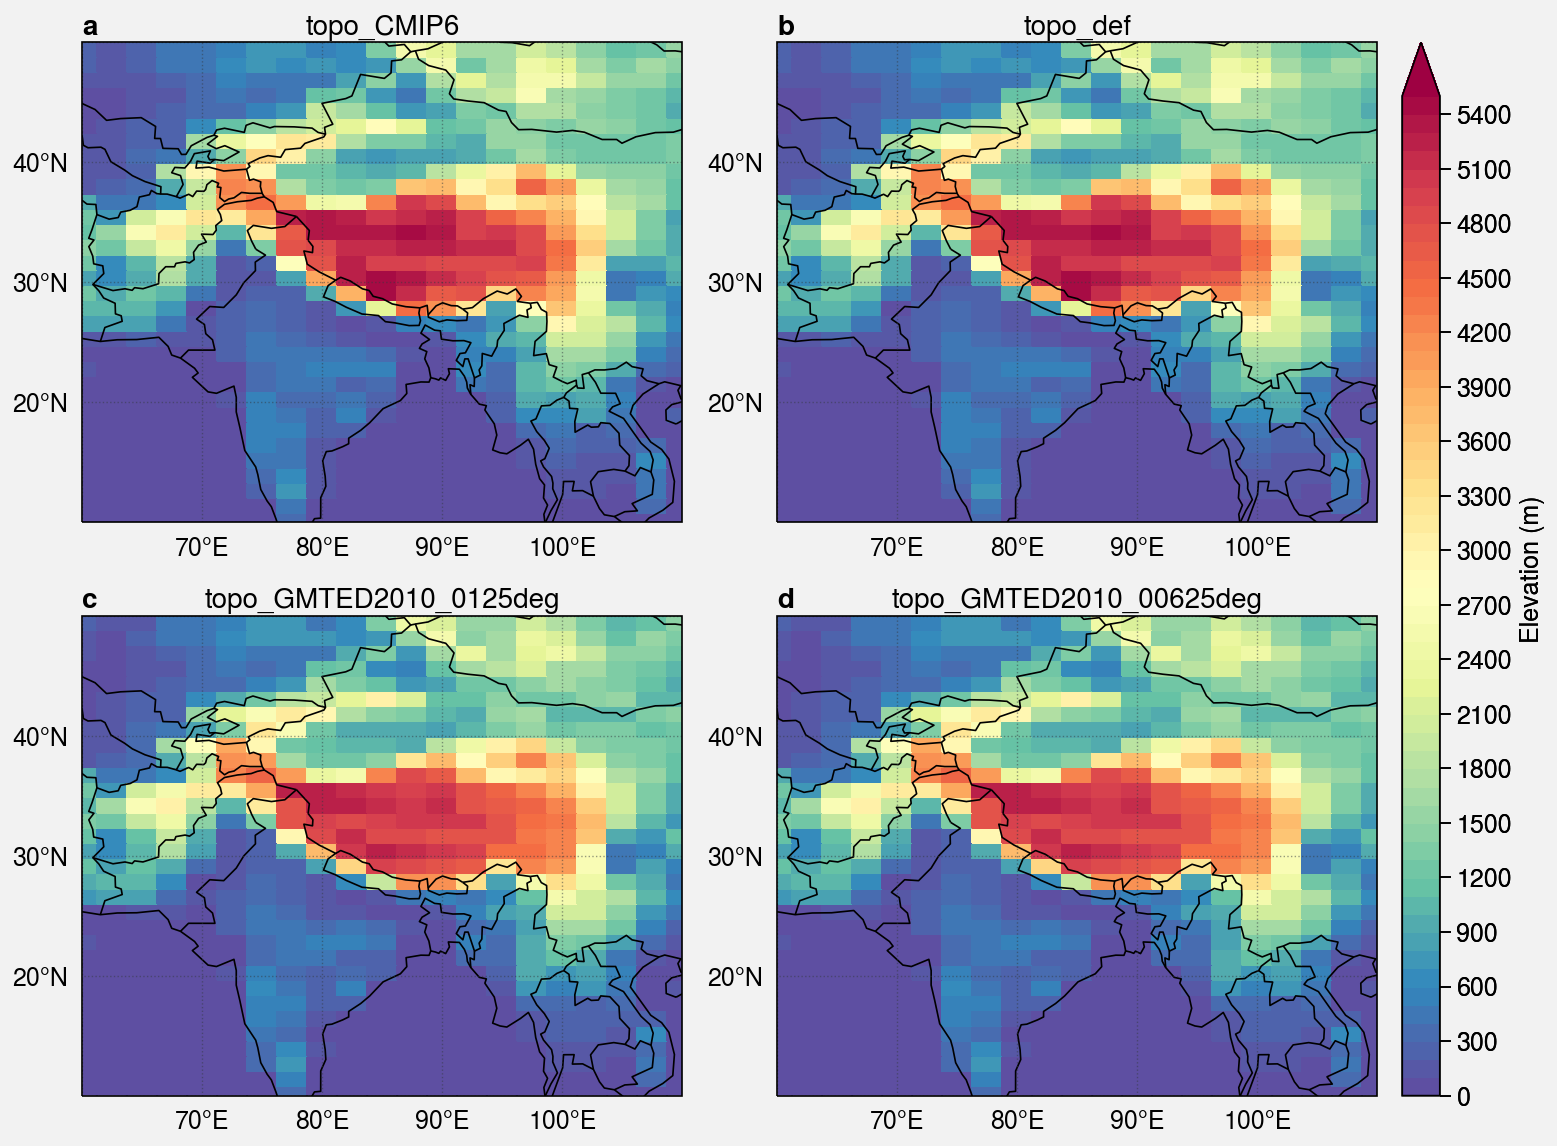

In [16]:
levels=plot.arange(0,5500,100)
cmap='Spectral'
extend='max'

# f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, axwidth=3)
f, axs = plot.subplots([[1, 2], [3, 4]], proj='cyl', axwidth=3)

axs[0].pcolormesh(topo_CMIP6.sel(lat=slice(10,50), lon=slice(60,110)), levels=levels, cmap=cmap, extend=extend)
axs[0].format(title='topo_CMIP6')

axs[1].pcolormesh(topo_def.sel(lat=slice(10,50), lon=slice(60,110)), levels=levels, cmap=cmap, extend=extend)
axs[1].format(title='topo_def')

axs[2].pcolormesh(topo_GMTED2010_0125deg.sel(lat=slice(10,50), lon=slice(60,110)), levels=levels, cmap=cmap, extend=extend)
axs[2].format(title='topo_GMTED2010_0125deg')

m = axs[3].pcolormesh(topo_GMTED2010_00625deg.sel(lat=slice(10,50), lon=slice(60,110)), levels=levels, cmap=cmap, extend=extend)
axs[3].format(title='topo_GMTED2010_00625deg')

f.colorbar(m, label='Elevation (m)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    borders=True, coast=True, abc=True,
    lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110)
)

# f.savefig("img/topo_resolution_comparison.png")
# f.savefig("img/topo_resolution_comparison.pdf")

# Differences

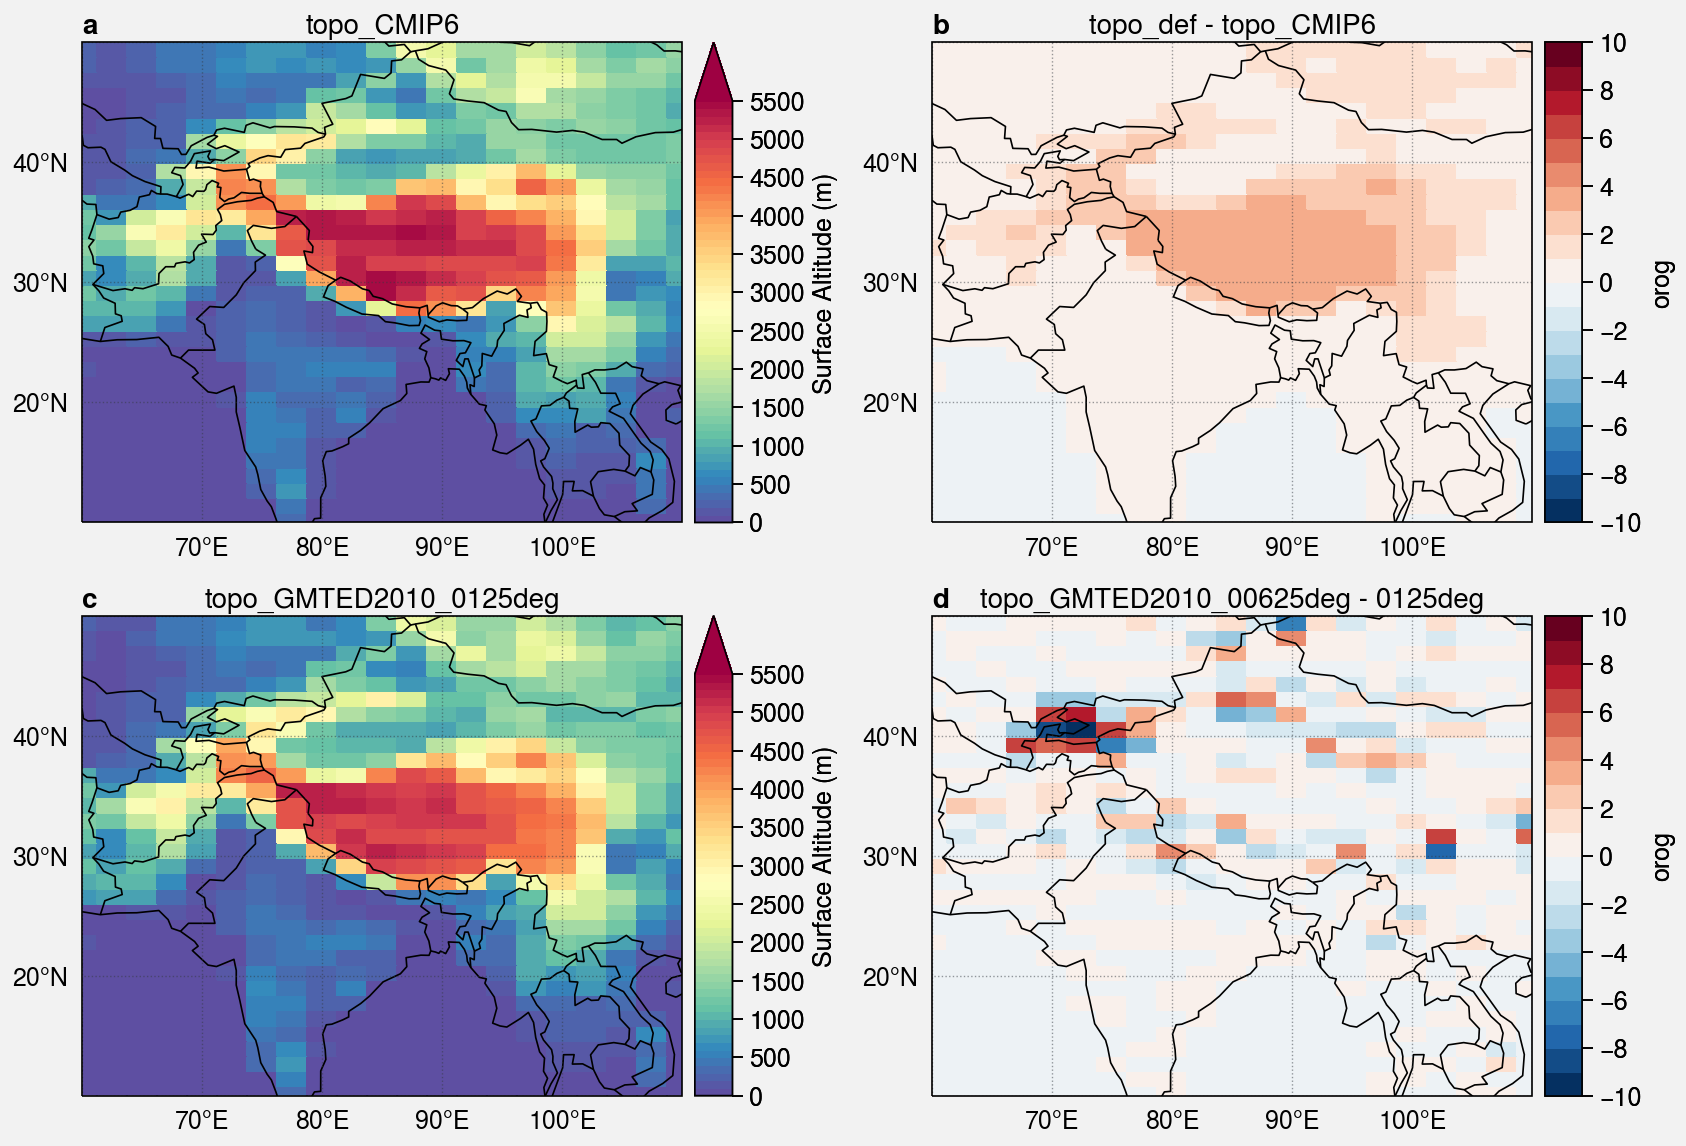

In [17]:
levels=plot.arange(0,5500,100)
cmap='Spectral'
extend='max'

levels_bias=plot.arange(-10,10,1)
cmap_bias='BuRd'
extend_bias='neither'

# f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, axwidth=3)
f, axs = plot.subplots([[1, 2], [3, 4]], proj='cyl', axwidth=3)

axs[0].pcolormesh(topo_CMIP6.sel(lat=slice(10,50), lon=slice(60,110)), levels=levels, cmap=cmap, extend=extend, colorbar='r')
axs[0].format(title='topo_CMIP6')

axs[1].pcolormesh((topo_def-topo_CMIP6).sel(lat=slice(10,50), lon=slice(60,110)), levels=levels_bias, cmap=cmap_bias, extend=extend_bias, colorbar='r')
axs[1].format(title='topo_def - topo_CMIP6')

axs[2].pcolormesh(topo_GMTED2010_0125deg.sel(lat=slice(10,50), lon=slice(60,110)), levels=levels, cmap=cmap, extend=extend, colorbar='r')
axs[2].format(title='topo_GMTED2010_0125deg')

axs[3].pcolormesh((topo_GMTED2010_00625deg-topo_GMTED2010_0125deg).sel(lat=slice(10,50), lon=slice(60,110)), levels=levels_bias, cmap=cmap_bias, extend=extend_bias, colorbar='r')
axs[3].format(title='topo_GMTED2010_00625deg - 0125deg')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    borders=True, coast=True, abc=True,
    lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110)
)

# f.savefig(".png")
# f.savefig(".pdf")

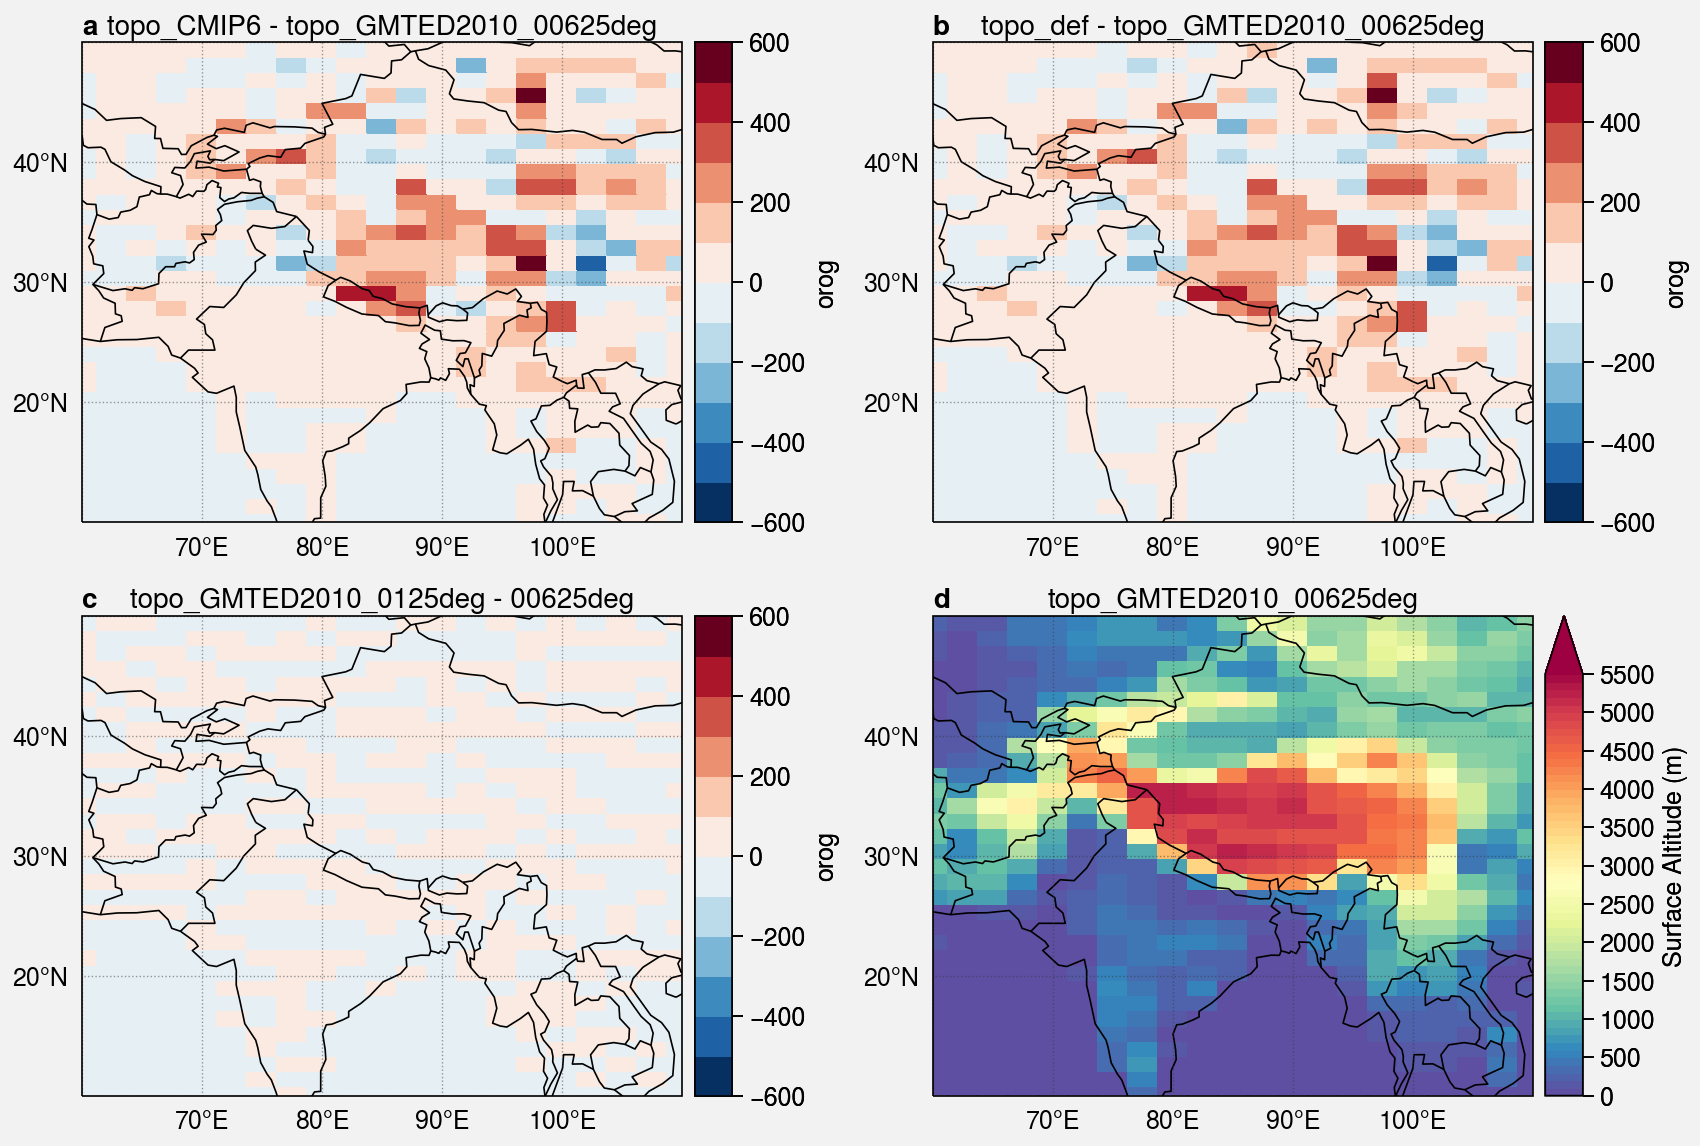

In [56]:
levels=plot.arange(0,5500,100)
cmap='Spectral'
extend='max'

levels_bias=plot.arange(-600,600,100)
cmap_bias='BuRd'
extend_bias='neither'

# f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, axwidth=3)
f, axs = plot.subplots([[1, 2], [3, 4]], proj='cyl', axwidth=3)

axs[0].pcolormesh((topo_CMIP6-topo_GMTED2010_00625deg).sel(lat=slice(10,50), lon=slice(60,110)), levels=levels_bias, cmap=cmap_bias, extend=extend_bias, colorbar='r')
axs[0].format(title='topo_CMIP6 - topo_GMTED2010_00625deg')

axs[1].pcolormesh((topo_def-topo_GMTED2010_00625deg).sel(lat=slice(10,50), lon=slice(60,110)), levels=levels_bias, cmap=cmap_bias, extend=extend_bias, colorbar='r')
axs[1].format(title='topo_def - topo_GMTED2010_00625deg')

axs[2].pcolormesh((topo_GMTED2010_0125deg-topo_GMTED2010_00625deg).sel(lat=slice(10,50), lon=slice(60,110)), levels=levels_bias, cmap=cmap_bias, extend=extend_bias, colorbar='r')
axs[2].format(title='topo_GMTED2010_0125deg - 00625deg')

axs[3].pcolormesh(topo_GMTED2010_00625deg.sel(lat=slice(10,50), lon=slice(60,110)), levels=levels, cmap=cmap, extend=extend, colorbar='r')
axs[3].format(title='topo_GMTED2010_00625deg')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    borders=True, coast=True, abc=True,
    lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110)
)

# f.savefig(".png")
# f.savefig(".pdf")

# Check with Laurent's files

In [18]:
topo_def_Laurent = get_topo('/data/mlalande/ELC_Laurent/ELC-RELIEF-DEF-144x142x79/ATM/Output/Grid/ELC-RELIEF-DEF-144x142x79_grilles_gcm.nc', topo_CMIP6)
topo_GMTED2010_0125deg_Laurent = get_topo('/data/mlalande/ELC_Laurent/ELC-RELIEF-GMTED-144x142x79/ATM/Output/Grid/ELC-RELIEF-GMTED-144x142x79_grilles_gcm.nc', topo_CMIP6)

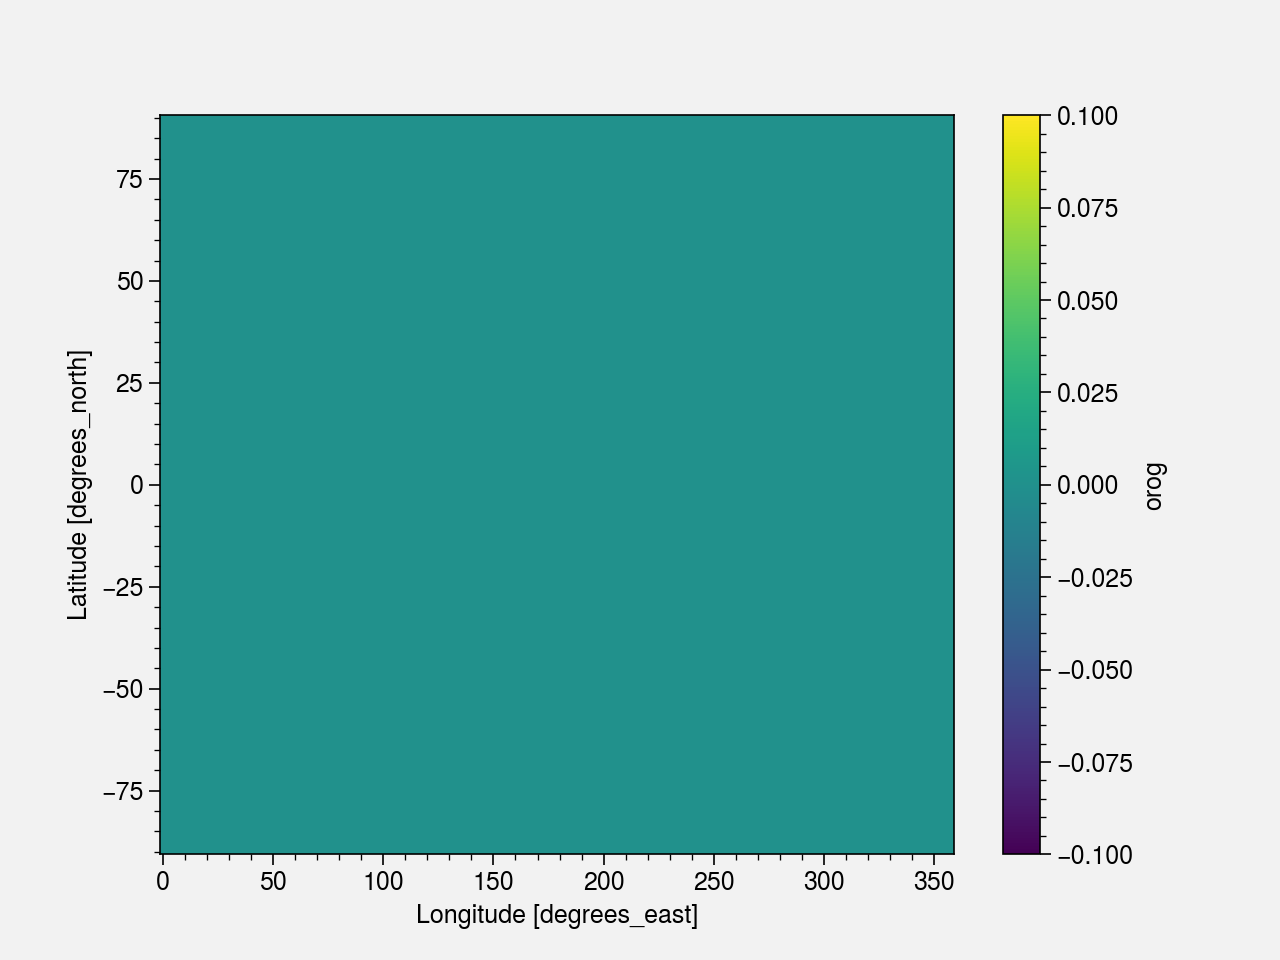

In [19]:
(topo_def_Laurent - topo_def).plot()

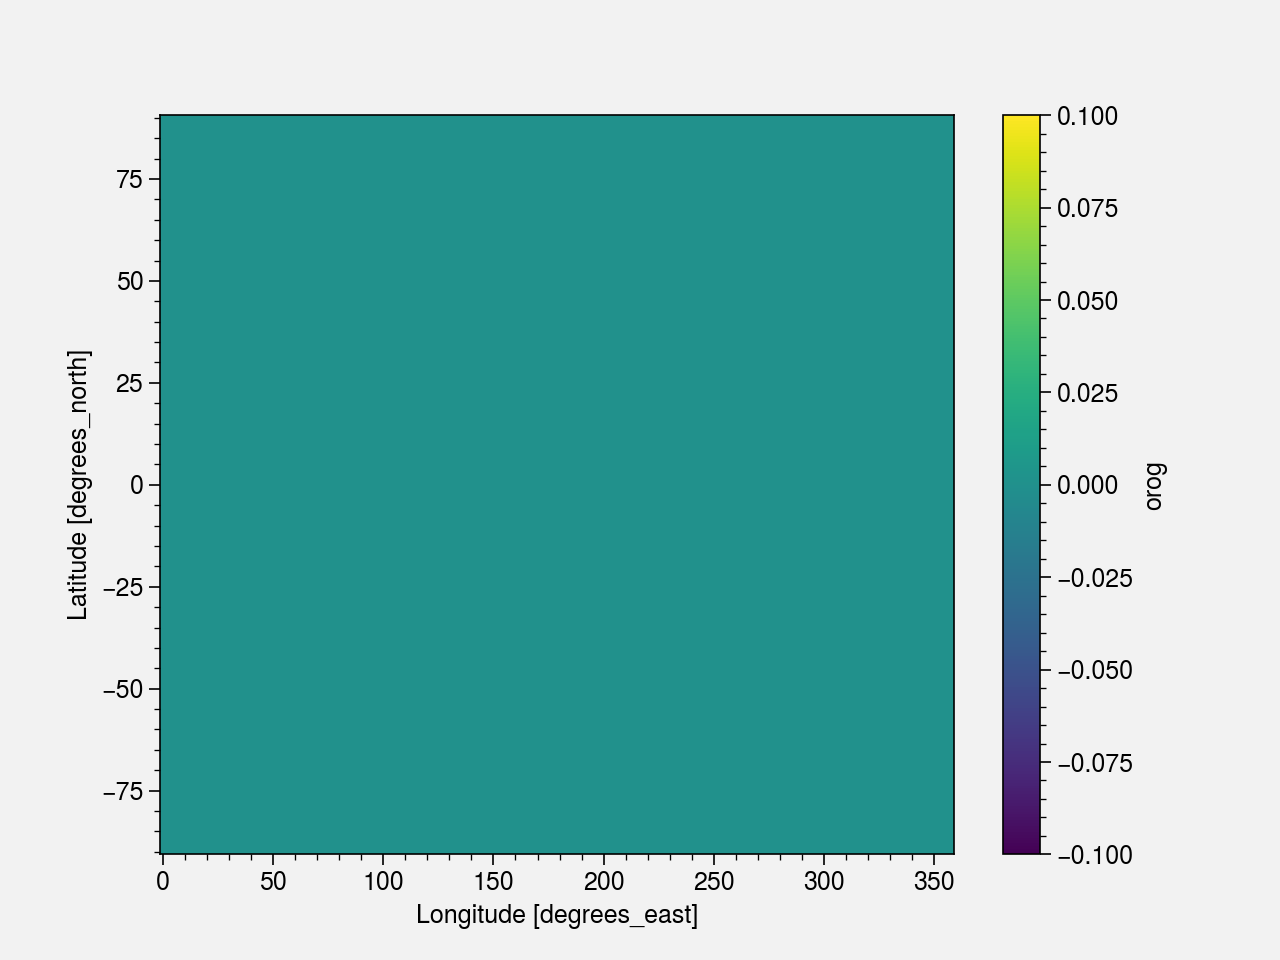

In [20]:
(topo_GMTED2010_0125deg_Laurent - topo_GMTED2010_0125deg).plot()

# Check with my "hand made" computation from GLOBE

In [21]:
topo_GLOBE_approx = xr.open_dataarray('~/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/mean_topo.nc')
topo_GLOBE_approx

<xarray.DataArray 'orog' (lat: 143, lon: 144)>
array([[2766.2896, 2768.7498, 2771.2778, ..., 2760.2864, 2762.1475, 2762.1475],
       [2679.6423, 2688.095 , 2696.1418, ..., 2656.141 , 2663.1135, 2663.1135],
       [2600.3545, 2619.7944, 2648.6519, ..., 2556.7124, 2571.3628, 2571.3628],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,    0.    ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

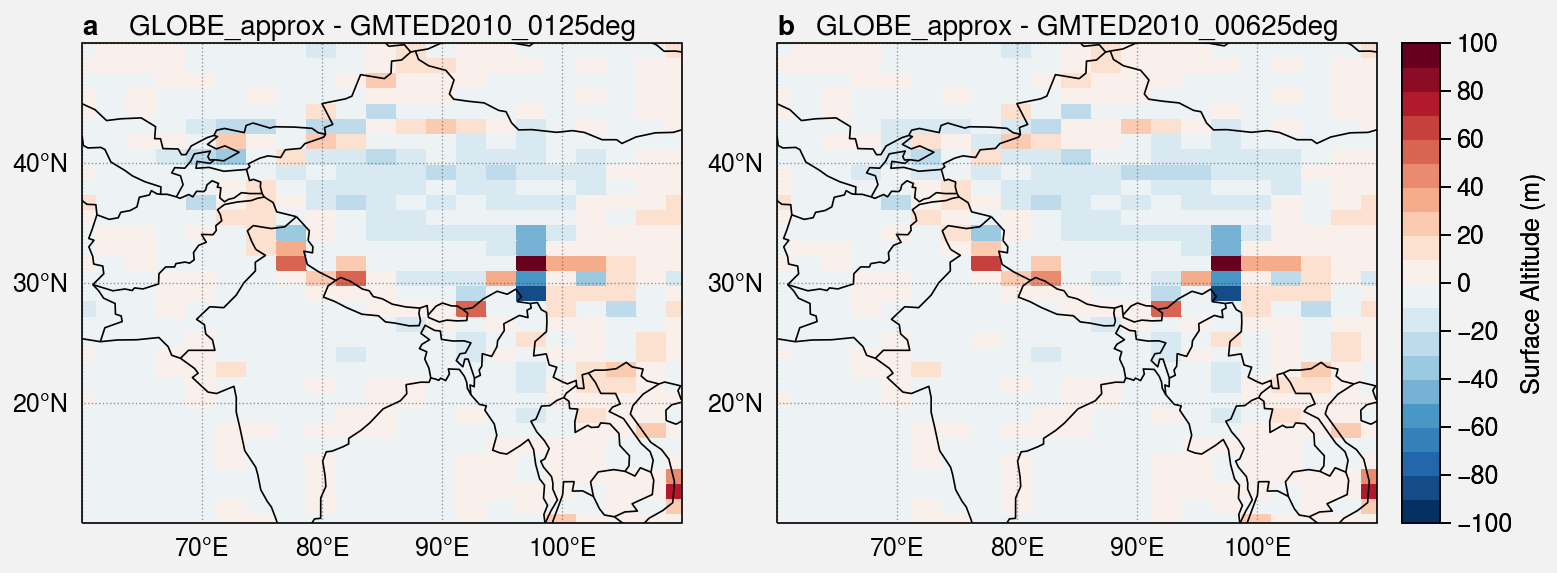

In [22]:
levels=plot.arange(0,5500,100)
cmap='Spectral'
extend='max'

levels_bias=plot.arange(-100,100,10)
cmap_bias='BuRd'
extend_bias='neither'

# f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, axwidth=3)
f, axs = plot.subplots([[1, 2]], proj='cyl', axwidth=3)

axs[0].pcolormesh((topo_GLOBE_approx-topo_GMTED2010_0125deg).sel(lat=slice(10,50), lon=slice(60,110)), levels=levels_bias, cmap=cmap_bias, extend=extend_bias)
axs[0].format(title='GLOBE_approx - GMTED2010_0125deg')

m = axs[1].pcolormesh((topo_GLOBE_approx-topo_GMTED2010_00625deg).sel(lat=slice(10,50), lon=slice(60,110)), levels=levels_bias, cmap=cmap_bias, extend=extend_bias)
axs[1].format(title='GLOBE_approx - GMTED2010_00625deg')

f.colorbar(m, label='Surface Altitude (m)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    borders=True, coast=True, abc=True,
    lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110)
)

# f.savefig(".png")
# f.savefig(".pdf")

# Check the std even if smoothed?

# Try phisnit/9.81

In [ ]:
phisinit = xr.open_dataset('/data/mlalande/ELC-144x142x79_clim/Output/Restart/ELC-144x142x79_clim_start.nc').phisinit/9.81
phisinit = phisinit.assign_coords({'rlatu': np.rad2deg(phisinit.rlatu), 'rlonv': np.rad2deg(phisinit.rlonv)})
topo_ref_phisinit = topo_CMIP6.copy()
topo_ref_phisinit.values = phisinit[:,:-1].roll(rlonv=int(topo_CMIP6.lon.size/2), roll_coords=True).sortby('rlatu').values

(topo_ref_phisinit-topo_CMIP6).sel(lat=slice(10,50), lon=slice(60,110)).plot()

Ok bon l'erreur vient probablement de l'imprecision de la multiplication/division par 9.81 (qui manque de précision ?). 